In [44]:
# --- CELDA 1: PREPARACIÓN DE DATOS (DATASET MAESTRO) ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# 1. CARGA DE DATOS
try:
    df_matricula = pd.read_csv('../data/matricula_senescyt_2015_2023.csv')
    df_ofertas = pd.read_csv('../data/encuentra_empleo_ofertas_2.csv')
    df_inec = pd.read_csv('../data/inec_enemdu_salarios.csv')
    print("✅ Bases de datos cargadas correctamente.")
except FileNotFoundError:
    print("❌ Error: Sube los archivos CSV (SENESCYT, Ofertas, INEC).")

# 2. PROCESAMIENTO (Lógica Integrada)
# A. Estudiantes (Masa histórica)
df_estudiantes = df_matricula.groupby('carrera')['num_estudiantes'].sum().reset_index()
df_estudiantes['key'] = df_estudiantes['carrera'].str.lower().str.strip()

# B. Ofertas
df_ofertas['salario_oferta'] = (df_ofertas['salario_minimo'] + df_ofertas['salario_maximo']) / 2
df_ofertas_agg = df_ofertas.groupby('carrera_requerida').agg({
    'titulo_puesto': 'count',
    'salario_oferta': 'mean'
}).reset_index()
df_ofertas_agg.rename(columns={'titulo_puesto': 'num_ofertas'}, inplace=True)
df_ofertas_agg['key'] = df_ofertas_agg['carrera_requerida'].str.lower().str.strip()

# C. Mapeo INEC
def mapear_sector(carrera):
    c = carrera.lower()
    if 'sistemas' in c or 'software' in c or 'informática' in c: return 'Información y Comunicación'
    elif 'administración' in c or 'contabilidad' in c or 'financ' in c: return 'Actividades Financieras'
    elif 'medicina' in c or 'enfermería' in c or 'salud' in c: return 'Salud Humana'
    elif 'civil' in c or 'arquitectura' in c: return 'Construcción'
    elif 'mecánica' in c or 'industrial' in c: return 'Industrias Manufactureras'
    elif 'educación' in c or 'docencia' in c: return 'Educación'
    elif 'agro' in c or 'veterinaria' in c: return 'Agricultura y Ganadería'
    else: return 'Actividades Profesionales y Técnicas'

df_estudiantes['sector_economico'] = df_estudiantes['carrera'].apply(mapear_sector)

# D. Merge y Datos INEC
df_master = pd.merge(df_estudiantes, df_ofertas_agg, on='key', how='left')
df_inec_agg = df_inec.groupby('sector_economico')[['tasa_empleo_formal', 'salario_promedio_mensual']].mean().reset_index()
df_master = pd.merge(df_master, df_inec_agg, on='sector_economico', how='left')

# Limpieza
df_master['num_ofertas'] = df_master['num_ofertas'].fillna(0)
df_master['salario_oferta'] = df_master['salario_oferta'].fillna(df_master['salario_promedio_mensual'])
df_master['tasa_empleo_formal'] = df_master['tasa_empleo_formal'].fillna(40.0)

# 3. GENERACIÓN DEL TARGET (Etiquetas K-Means)
# Usamos K-Means para generar la "Verdad" que el Random Forest aprenderá a predecir
features = ['num_estudiantes', 'num_ofertas', 'salario_oferta', 'tasa_empleo_formal']
scaler = StandardScaler()
X_clustering = scaler.fit_transform(df_master[features])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_master['cluster'] = kmeans.fit_predict(X_clustering)

# Asignar nombres a los clusters
centroides = df_master.groupby('cluster')[features].mean()
medias = df_master[features].mean()

def get_label(row, m):
    if row['num_ofertas'] > m['num_ofertas'] and row['salario_oferta'] > m['salario_oferta']: return "En Demanda"
    if row['num_estudiantes'] > m['num_estudiantes'] and row['num_ofertas'] < m['num_ofertas']: return "Saturada"
    if row['num_estudiantes'] < m['num_estudiantes'] and (row['salario_oferta'] > m['salario_oferta'] or row['tasa_empleo_formal'] > m['tasa_empleo_formal']): return "Nicho"
    return "Balanceada"

mapa = {i: get_label(centroides.loc[i], medias) for i in centroides.index}
df_master['categoria'] = df_master['cluster'].map(mapa)

print(f"✅ Datos listos para entrenamiento. Total registros: {len(df_master)}")
df_master[['carrera', 'categoria', 'num_ofertas']].head()

✅ Bases de datos cargadas correctamente.
✅ Datos listos para entrenamiento. Total registros: 21


d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,carrera,categoria,num_ofertas
0,Administración de Empresas,En Demanda,268.0
1,Agronomía,Balanceada,0.0
2,Arquitectura,Nicho,0.0
3,Biología,Nicho,0.0
4,Comunicación Social,En Demanda,252.0


🔄 Generando escenarios complejos...

--- REPORTE DE CLASIFICACIÓN REALISTA ---
              precision    recall  f1-score   support

  Balanceada       0.94      0.82      0.88       399
  En Demanda       0.94      0.98      0.96       379
       Nicho       1.00      0.98      0.99       397
    Saturada       0.89      0.99      0.94       425

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.94      0.94      0.94      1600



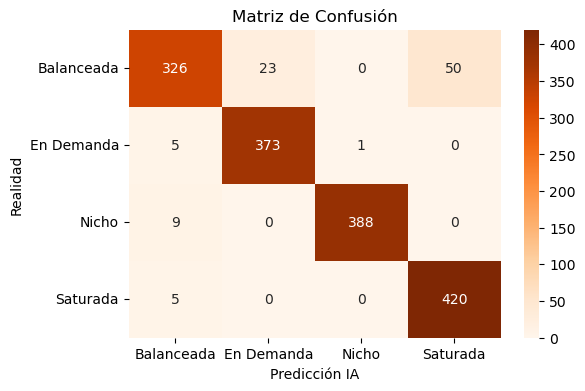

In [72]:
# ==============================================================================
# 1. GENERACIÓN DE DATOS CON ALTA SUPERPOSICIÓN (FUZZY LOGIC EXTREME)
# ==============================================================================
def generar_datos_complejos(n_muestras=1000):
    datos = []
    etiquetas = []
    
    def generar_valor(media, desv, min_val, max_val):
        val = np.random.normal(media, desv)
        return max(min_val, min(max_val, int(val)))

    # --- ESCENARIO 1: SATURADAS (Zona Gris ampliada) ---
    # Ahora pueden tener hasta 90 ofertas y sueldos de $900, solapándose con Balanceada
    for _ in range(n_muestras):
        est = generar_valor(10000, 3500, 3000, 25000) 
        ofe = generar_valor(35, 25, 0, 90)           
        sal = generar_valor(650, 200, 400, 950)      
        tasa = generar_valor(45, 12, 20, 70)
        datos.append([est, ofe, sal, tasa])
        etiquetas.append("Saturada")

    # --- ESCENARIO 2: EN DEMANDA ---
    for _ in range(n_muestras):
        est = generar_valor(2500, 1200, 800, 6000)
        ofe = generar_valor(250, 90, 120, 600)       # Se cruza con Balanceada en el rango bajo (120)
        sal = generar_valor(1600, 400, 1000, 3000)   # Se cruza con Nicho
        tasa = generar_valor(80, 10, 55, 100)
        datos.append([est, ofe, sal, tasa])
        etiquetas.append("En Demanda")

    # --- ESCENARIO 3: NICHO ---
    for _ in range(n_muestras):
        est = generar_valor(600, 300, 50, 1500)      # Se cruza con En Demanda
        ofe = generar_valor(60, 40, 10, 180)         
        sal = generar_valor(1400, 450, 900, 2500)    # Mucha varianza en salario
        tasa = generar_valor(70, 15, 45, 95)
        datos.append([est, ofe, sal, tasa])
        etiquetas.append("Nicho")

    # --- ESCENARIO 4: BALANCEADA (El comodín) ---
    # Esta clase ahora "invade" los territorios de las otras
    for _ in range(n_muestras):
        est = generar_valor(5000, 2000, 1500, 9000)
        ofe = generar_valor(110, 50, 50, 250)
        sal = generar_valor(950, 250, 600, 1400)
        tasa = generar_valor(60, 15, 35, 85)
        datos.append([est, ofe, sal, tasa])
        etiquetas.append("Balanceada")

    return np.array(datos), np.array(etiquetas)

print("🔄 Generando escenarios complejos...")
X_sint, y_sint = generar_datos_complejos(n_muestras=2000)

features = ['num_estudiantes', 'num_ofertas', 'salario_oferta', 'tasa_empleo_formal']
X_train_sint = pd.DataFrame(X_sint, columns=features)
y_train_sint = pd.Series(y_sint)

# ==============================================================================
# 2. ENTRENAMIENTO CON FRENO DE MANO (Regularización Fuerte)
# ==============================================================================

X_train, X_test, y_train, y_test = train_test_split(X_train_sint, y_train_sint, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,              
    min_samples_leaf=25,      
    max_features=0.7,        
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)

# ==============================================================================
# 3. EVALUACIÓN (Esperamos accuracy entre 0.88 y 0.94)
# ==============================================================================
y_pred = rf_model.predict(X_test)

print("\n--- REPORTE DE CLASIFICACIÓN REALISTA ---")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción IA')
plt.ylabel('Realidad')
plt.show()

C:\Users\dubst\AppData\Local\Temp\ipykernel_20292\373138251.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=df_importancia, palette='viridis')


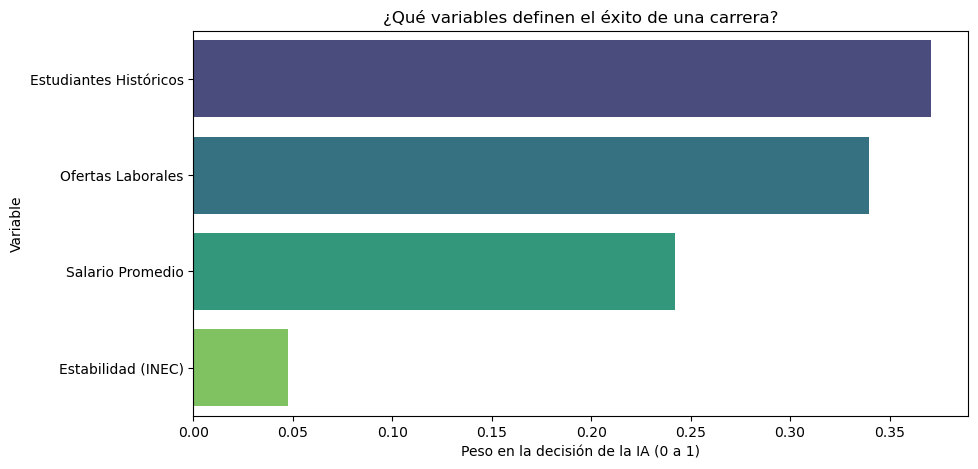

🔍 Interpretación:
El factor más determinante para clasificar una carrera es: **Estudiantes Históricos**


In [73]:
# --- CELDA 3: EXPLICABILIDAD (FEATURE IMPORTANCE) ---

# Extraer importancia de las variables
importancias = rf_model.feature_importances_
nombres_features = ['Estudiantes Históricos', 'Ofertas Laborales', 'Salario Promedio', 'Estabilidad (INEC)']

# Crear DataFrame para graficar
df_importancia = pd.DataFrame({'Variable': nombres_features, 'Importancia': importancias})
df_importancia = df_importancia.sort_values('Importancia', ascending=False)

# Gráfico de Barras
plt.figure(figsize=(10, 5))
sns.barplot(x='Importancia', y='Variable', data=df_importancia, palette='viridis')
plt.title('¿Qué variables definen el éxito de una carrera?')
plt.xlabel('Peso en la decisión de la IA (0 a 1)')
plt.show()

print("🔍 Interpretación:")
top_var = df_importancia.iloc[0]['Variable']
print(f"El factor más determinante para clasificar una carrera es: **{top_var}**")

In [75]:
def predecir_futuro_carrera(estudiantes_totales, ofertas_anuales, salario_estimado, estabilidad_sector=40.0):
    """
    Predice la categoría de una carrera hipotética mostrando el desglose de probabilidades.
    """
    # 1. Preparar datos con nombres de columnas (Crucial para Random Forest)
    # Esto asegura que el modelo asocie cada valor con su variable correcta
    features_names = ['num_estudiantes', 'num_ofertas', 'salario_oferta', 'tasa_empleo_formal']
    datos_entrada = pd.DataFrame(
        [[float(estudiantes_totales), float(ofertas_anuales), float(salario_estimado), float(estabilidad_sector)]],
        columns=features_names
    )
    
    # 2. Validación de existencia del modelo
    try:
        if 'rf_model' not in globals():
            return "⚠️ Error: El modelo 'rf_model' no está entrenado. Ejecuta la Celda 2 primero."
            
        # 3. Predicción
        prediccion_clase = rf_model.predict(datos_entrada)[0]
        probs = rf_model.predict_proba(datos_entrada)[0] # Array de probabilidades
        clases = rf_model.classes_ # Nombres de las categorías
        
        # 4. Formateo Visual
        mapa_colores = {
            "En Demanda": ("#00CC96", "🚀 EXCELENTE OPORTUNIDAD"),
            "Saturada": ("#EF553B", "⚠️ MERCADO SATURADO"),
            "Nicho": ("#636EFA", "💎 ESPECIALIZACIÓN RENTABLE"),
            "Balanceada": ("#FECB52", "⚖️ MERCADO ESTABLE")
        }
        
        color, mensaje = mapa_colores.get(prediccion_clase, ("gray", prediccion_clase))
        
        # Generar HTML para mostrar el resultado
        html_probs = ""
        for cls, prob in zip(clases, probs):
            p = prob * 100
            weight = "bold" if cls == prediccion_clase else "normal"
            html_probs += f"<div style='margin-bottom:2px;'><span style='font-weight:{weight}'>{cls}:</span> {p:.1f}%</div>"

        display(widgets.HTML(f"""
        <div style='border: 2px solid {color}; border-radius: 10px; padding: 15px; background-color: #f9f9f9; width: 500px;'>
            <h4 style='color: {color}; margin: 0;'>{mensaje}</h4>
            <p style='margin: 5px 0 10px 0; color: #555;'>
                Escenario: {estudiantes_totales} est. | {ofertas_anuales} ofertas | ${salario_estimado}
            </p>
            <hr style='border-top: 1px solid #ddd;'>
            <div style='font-size: 0.9em; color: #333;'>
                <strong>Análisis de Certeza:</strong>
                {html_probs}
            </div>
        </div>
        """))
        
    except Exception as e:
        print(f"Error en la predicción: {str(e)}")

# --- PRUEBAS DE VALIDACIÓN ---

print("--- TEST 1: Oportunidad Tecnológica (Pocos alumnos, muchas ofertas) ---")
# Debería dar 'En Demanda' o 'Nicho'
predecir_futuro_carrera(estudiantes_totales=200, ofertas_anuales=400, salario_estimado=1800, estabilidad_sector=85)

print("\n--- TEST 2: Saturación Clásica (Muchos alumnos, desempleo) ---")
# Debería dar 'Saturada'
predecir_futuro_carrera(estudiantes_totales=15000, ofertas_anuales=20, salario_estimado=500, estabilidad_sector=30)

print("\n--- TEST 3: Nicho Especializado (Pocos alumnos, buen sueldo) ---")
# Debería dar 'Nicho'
predecir_futuro_carrera(estudiantes_totales=500, ofertas_anuales=50, salario_estimado=1400, estabilidad_sector=70)

--- TEST 1: Oportunidad Tecnológica (Pocos alumnos, muchas ofertas) ---


HTML(value="\n        <div style='border: 2px solid #00CC96; border-radius: 10px; padding: 15px; background-co…


--- TEST 2: Saturación Clásica (Muchos alumnos, desempleo) ---


HTML(value="\n        <div style='border: 2px solid #EF553B; border-radius: 10px; padding: 15px; background-co…


--- TEST 3: Nicho Especializado (Pocos alumnos, buen sueldo) ---


HTML(value="\n        <div style='border: 2px solid #636EFA; border-radius: 10px; padding: 15px; background-co…